In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import FancyBboxPatch
import seaborn as sns
from scipy.stats.mstats import winsorize
#from __future__ import division, print_function
from builtins import reversed
from builtins import map, zip
from collections.abc import MutableSequence, Sequence
import copy
from math import ceil
from numbers import Complex, Integral, Real
import sys
import warnings
from sklearn.covariance import EmpiricalCovariance
from sklearn.preprocessing import StandardScaler
from scipy.stats import gaussian_kde
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import kendalltau
import cvxpy as cp
from scipy.optimize import minimize
from scipy.cluster.hierarchy import linkage
from scipy.spatial.distance import squareform
from scipy.stats import rankdata

### **2) Address the following :** 
(a) Create an equally weighed (EW) portfolio of all 14 assets in the grid, as at i) the previous peak date, datePP: 11-Sep-2021, and at ii) the trough date, dateTr: 21-Nov-2022 

An equally weighted (EW) portfolio gives every asset within it the same weight, regardless of its size or value. This means each asset in the portfolio contributes equally to its overall performance. In our case, $w \in \R^{14}$ and $w_i = \frac{1}{14}$.

In [9]:
datePP = pd.Timestamp('2021-09-11')
dateTr = pd.Timestamp('2022-11-21')

# Lets take a wealth of one
# Compute equal weights
n_assets = len(df.columns)
w = np.repeat(1/n_assets, n_assets)

prices_PP = df.loc[datePP]
prices_Tr = df.loc[dateTr]

Composition = 1/(prices_PP*n_assets)
pf_value_PP = np.dot(Composition, prices_PP)
pf_value_Tr = np.dot(Composition, prices_Tr)
print("Portfolio value at the PP date: ", pf_value_PP)
print("Portfolio value at the Tr date: ", pf_value_Tr)


Portfolio value at the PP date:  1.0
Portfolio value at the Tr date:  0.4709923177180544


In [10]:
print((prices_Tr-prices_PP)*100/prices_PP)

ADA-USD    -88.455994
BCH-USD    -83.780386
BTC-USD    -65.106168
DOGE-USD   -69.058482
ETH-USD    -66.140710
LINK-USD   -78.262963
LTC-USD    -65.686275
MANA-USD   -55.603656
XLM-USD    -74.086154
XRP-USD    -66.265060
SPXT        -9.746314
XCMP       -26.384614
SOFR         1.235710
VIX          6.730310
dtype: float64


(b) Create sample covariance matrices at each date (datePP; dateTr) for use in estimation and
consider: How much data do you need? (Lopez De Prado, 2016 contains a useful expression).
State the size of your chosen data window and justify.

In general, we need at least $\frac{1}{2}N(N+1)$ independent and identically distributed (IID) observations in order to estimate a covariance matrix of size N that is not singular. (Lopez De Prado, 2016) \
In our case $N=14$, so we need at least 105 observations. \
We choose to use a window of 252 business days rather than 365 calendar days because it aligns with the actual trading calendar and still captures a full cycle of market events. This avoids having to fill every Saturday and Sunday with artificial “0%” asset-index returns, which would underestimate asset-index volatility and attenuate crypto–asset-index covariances. By incorporating each weekend’s actual crypto movements into Monday’s return, we preserve the true risk dynamics in both traditional and 24/7 markets.

In [11]:
# define parameters
datePP = pd.Timestamp('2021-09-11')
dateTr = pd.Timestamp('2022-11-21')
window = 252  # days in window

# extract rolling windows ending on each date
rets_PP = rets.loc[:datePP].iloc[-window:]
rets_Tr = rets.loc[:dateTr].iloc[-window:]

# compute sample covariance matrices
cov_PP = rets_PP.cov()
cov_Tr = rets_Tr.cov()

# quick check
print("Covariance at peak date:\n", cov_PP)
print("Covariance at trough date:\n", cov_Tr)

Covariance at peak date:
                ADA-USD       BCH-USD       BTC-USD      DOGE-USD  \
ADA-USD   6.301276e-03  3.265476e-03  2.245810e-03  3.056172e-03   
BCH-USD   3.265476e-03  4.716236e-03  2.304742e-03  3.197576e-03   
BTC-USD   2.245810e-03  2.304742e-03  2.230743e-03  2.083167e-03   
DOGE-USD  3.056172e-03  3.197576e-03  2.083167e-03  8.729764e-03   
ETH-USD   3.106309e-03  3.014479e-03  2.178210e-03  2.607808e-03   
LINK-USD  3.959389e-03  3.925768e-03  2.536120e-03  3.538823e-03   
LTC-USD   3.109285e-03  3.467482e-03  2.405071e-03  3.002237e-03   
MANA-USD  3.187733e-03  3.171142e-03  2.312921e-03  2.765832e-03   
XLM-USD   4.323815e-03  3.661094e-03  2.277242e-03  3.424142e-03   
XRP-USD   3.477479e-03  2.992968e-03  1.941929e-03  3.185636e-03   
SPXT      1.148811e-04  8.165337e-05  7.753273e-05  8.976920e-05   
XCMP      1.664028e-04  1.239069e-04  1.236044e-04  8.637582e-05   
SOFR      7.570365e-09  1.056492e-08  6.439165e-09 -2.603577e-09   
VIX      -1.051683e-03

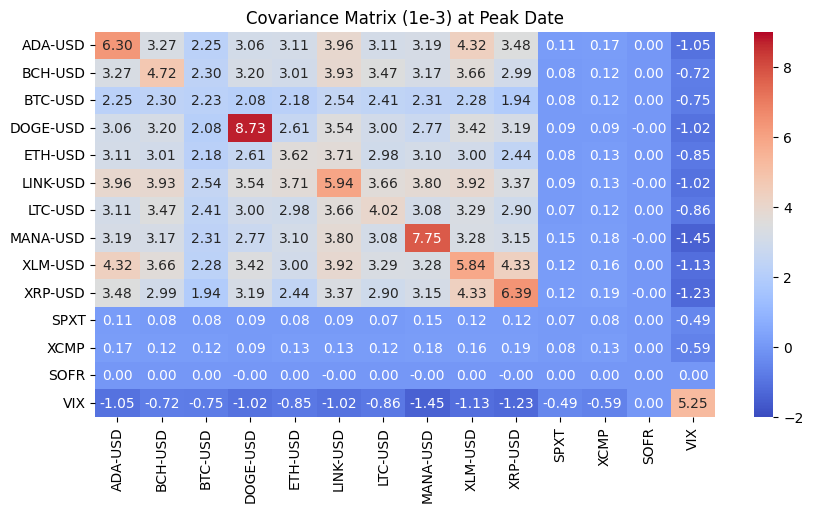

In [12]:
plt.figure(figsize=(10, 5))
sns.heatmap(cov_PP*1000, annot=True,fmt=".2f", cmap="coolwarm", vmin=-2, vmax=9)
plt.title("Covariance Matrix (1e-3) at Peak Date")     
plt.show()

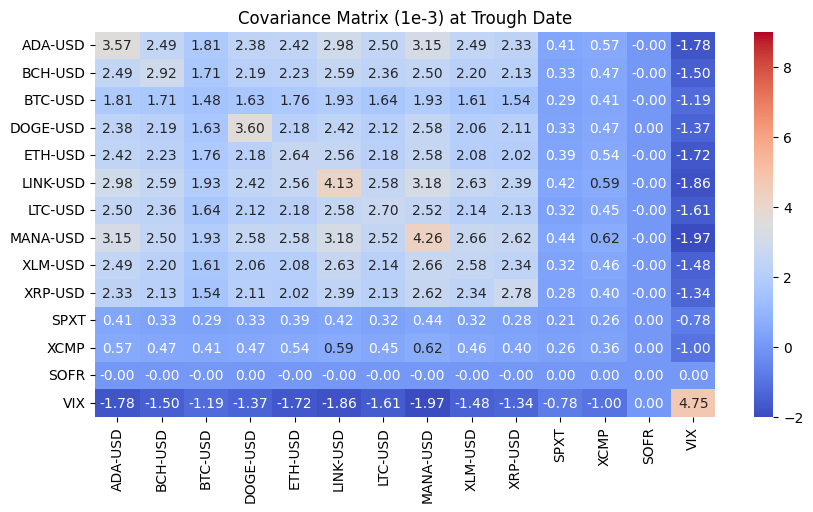

In [13]:
plt.figure(figsize=(10, 5))
sns.heatmap(cov_Tr*1000, annot=True, fmt=".2f", cmap="coolwarm",vmin=-2, vmax=9)
plt.title("Covariance Matrix (1e-3) at Trough Date")     
plt.show()

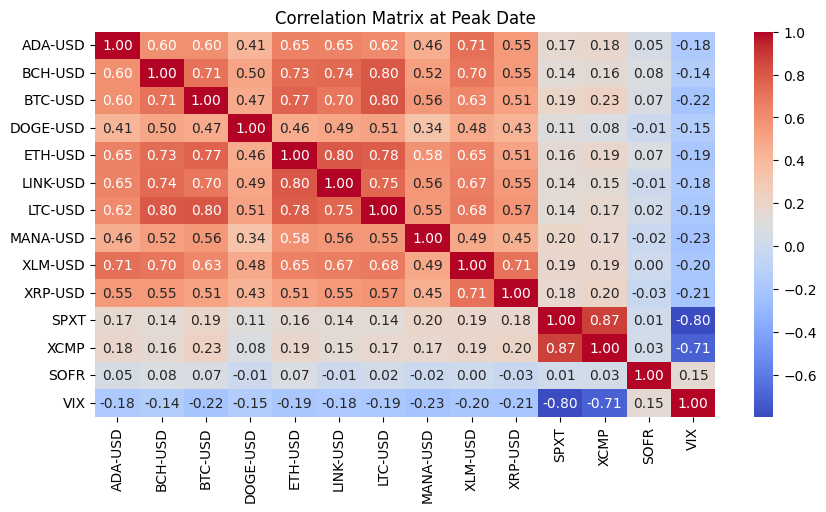

In [14]:
plt.figure(figsize=(10, 5))
sns.heatmap(rets_PP.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix at Peak Date")     
plt.show()

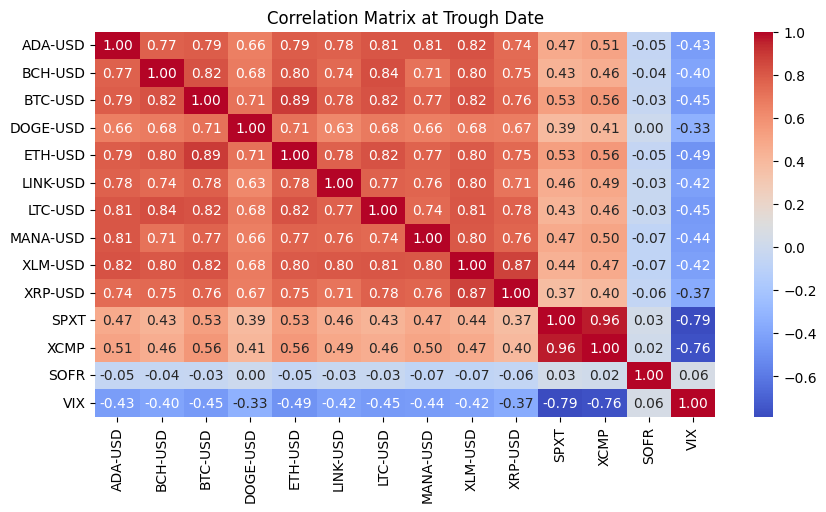

In [15]:
plt.figure(figsize=(10, 5))
sns.heatmap(rets_Tr.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix at Trough Date")     
plt.show()

(c) Now clean the covariance matrix (this may need decomposition into correlations and volatilities) using the eigenvalues clipping method (method no 3), as in Bouchaud et al. (2016). \
Compare and contrast the raw sample covariance matrix with the cleaned version: create helpful 3D visualizations, kernel density plots of their respective eigen-spectra, and contrast their respective condition numbers: what do you notice?

The Eigenvalues clipping (Bouchaud & Potters 2011) method keep the $[N\alpha]$ top eigenvalues and shrink the others to a constant $\gamma$ that preserves the trace, $\text{Tr}(\Xi^{\text{clip}})=\text{Tr}(E)=N:$ 
$$
\Xi^{\mathrm{clip.}}
\;:=\;
\sum_{k=1}^{N} \xi_{k}^{\mathrm{clip.}}\;u_{k}u_{k}^{*},
\quad
\xi_{k}^{\mathrm{clip.}}
\;:=\;
\begin{cases}
\lambda_{k}, & k \le \bigl\lceil N\alpha \bigr\rceil,\\
\gamma,      & \text{otherwise.}
\end{cases}$$
A simple procedure to choose $\alpha$ is to assume that all empirical eigenvalues beyond the Marčenko and Pastur upper edge can be deemed to contain some signal and are therefore kept without change. This is the procedure we have chosen to follow.
Additionnaly, we choose to force our reconstructed correlation matrix to have all 1's on the diagonal before getting our covariance matrix. We do so because we want a "real" correlation matrix, which has all 1's on the diagonals (The correlation of a random variable with itself is always 1). We also tested without it, and we observed better results by forcing the diagonal to 1.

We use code from : https://github.com/GGiecold/pyRMT/blob/main/pyRMT.py

In [16]:
def marcenkoPastur(X):
    # Marcenko-Pastur bounds
    T, N = X.shape
    q = N / float(T)
    
    lambda_min = (1 - np.sqrt(q))**2
    lambda_max = (1 + np.sqrt(q))**2

    return (lambda_min, lambda_max)



def clipped(X):
    
    T, N = X.shape
    ec = EmpiricalCovariance(store_precision=False,
                             assume_centered=True)
    ec.fit(X)
    E = ec.covariance_
    
    inverse_std = 1./np.sqrt(np.diag(E))
    E *= inverse_std
    E *= inverse_std.reshape(-1, 1)

    # Décomposition spectrale
    eigvals, eigvecs = np.linalg.eigh(E)
    eigvecs = eigvecs.T

    # PRINT avant clipping to check
    #print("Eigenvalues before clipping:", eigvals)

    # --- Construction du vecteur des valeurs propres clipées
    (lambda_min, lambda_max) = marcenkoPastur(X)
    xi_clipped = np.where(eigvals >= lambda_max, eigvals, np.nan)
    
    # Calcul de gamma et remplacement des NaN
    gamma = float(E.trace() - np.nansum(xi_clipped))
    gamma /= np.isnan(xi_clipped).sum()
    xi_clipped = np.where(np.isnan(xi_clipped), gamma, xi_clipped)

    # PRINT après clipping to check
    #print("Eigenvalues after clipping (γ for the bulk):", xi_clipped)

    # Reconstruction de la matrice clipée
    E_clipped = np.zeros((N, N), dtype=float)
    for xi, eigvec in zip(xi_clipped, eigvecs):
        eigvec = eigvec.reshape(-1, 1)
        E_clipped += xi * eigvec.dot(eigvec.T)
        
    tmp = 1./np.sqrt(np.diag(E_clipped))
    E_clipped *= tmp
    E_clipped *= tmp.reshape(-1, 1)
    
    
    std = 1./inverse_std
    E_clipped *= std
    E_clipped *= std.reshape(-1, 1)

    return E_clipped

In [17]:
cov_PP_clean = clipped(rets_PP)
cov_Tr_clean = clipped(rets_Tr)

In [18]:
def compare_covariances(cov_raw, cov_clean, label):
    C_raw   = cov_raw.values if hasattr(cov_raw, 'values') else cov_raw
    C_clean = cov_clean.values if hasattr(cov_clean, 'values') else cov_clean
    n = C_raw.shape[0]

    # 3D surface plots of the matrices 
    X, Y = np.meshgrid(np.arange(n), np.arange(n))
    fig = plt.figure(figsize=(10,4))
    
    ax = fig.add_subplot(121, projection='3d')
    ax.plot_surface(X, Y, C_raw,  rstride=1, cstride=1,cmap='viridis')
    ax.set_title(f'Covariance difference (Raw - Clean) ({label})')
    ax.set_xlabel('i'); ax.set_ylabel('j')
    
    ax = fig.add_subplot(122, projection='3d')
    ax.plot_surface(X, Y, C_clean, rstride=1, cstride=1,cmap='viridis')
    ax.set_title(f'Percentage difference between Raw and Clean ({label})')
    ax.set_xlabel('i'); ax.set_ylabel('j')
    
    plt.tight_layout()
    plt.show()



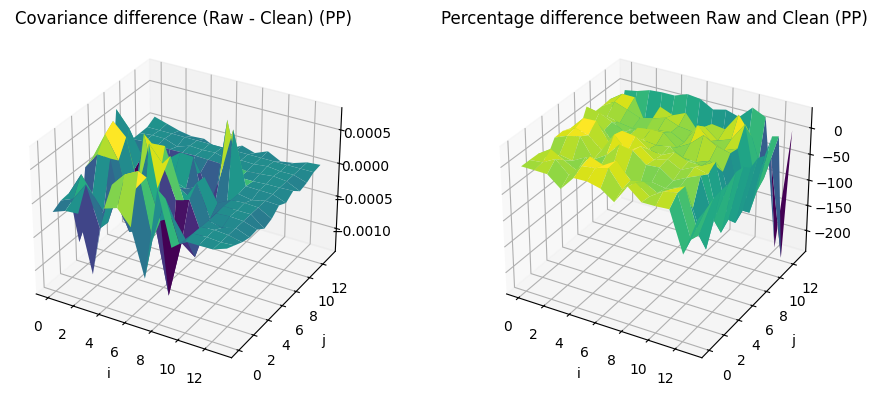

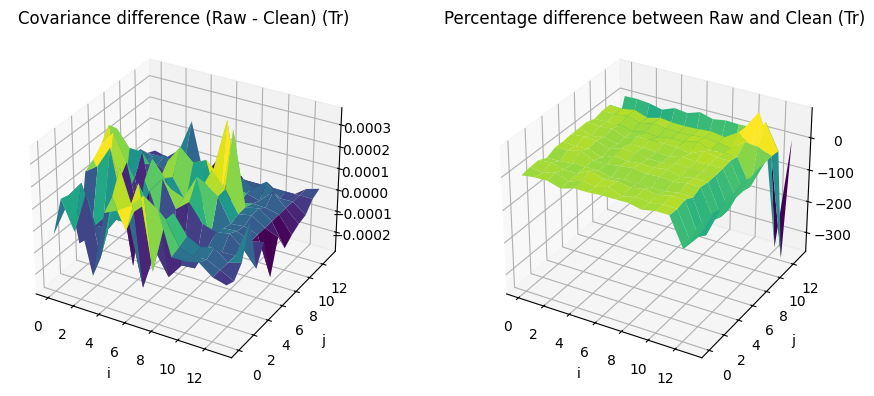

In [19]:
# Run for both periods
compare_covariances(cov_PP-cov_PP_clean,((cov_PP-cov_PP_clean)/cov_PP_clean)*100,'PP')
compare_covariances(cov_Tr-cov_Tr_clean,100*((cov_Tr-cov_Tr_clean)/cov_Tr_clean),'Tr')

In [20]:
def compare_eigenvalues(C_raw, C_clean, label):
# KDE of eigenvalue spectra 
    eigs_raw   = np.linalg.eigvalsh(C_raw)
    eigs_clean = np.linalg.eigvalsh(C_clean)
    kde_raw    = gaussian_kde(eigs_raw)
    kde_clean  = gaussian_kde(eigs_clean)
    
    xs = np.linspace(min(eigs_raw.min(), eigs_clean.min()),
                     max(eigs_raw.max(), eigs_clean.max()), 300)
    plt.figure()
    plt.plot(xs, kde_raw(xs),   label='Raw')
    plt.plot(xs, kde_clean(xs), label='Cleaned')
    plt.axhline(y=0, color='k', linestyle='--', lw=1)
    plt.title(f'Eigenvalue Density ({label})')
    plt.xlabel('Eigenvalue'); plt.ylabel('Density')
    plt.legend()
    plt.show()
# Condition numbers 
    cond_raw   = np.linalg.cond(C_raw)
    cond_clean = np.linalg.cond(C_clean)
    print(f"{label} condition number → raw: {cond_raw:.2e},  cleaned: {cond_clean:.2e}")

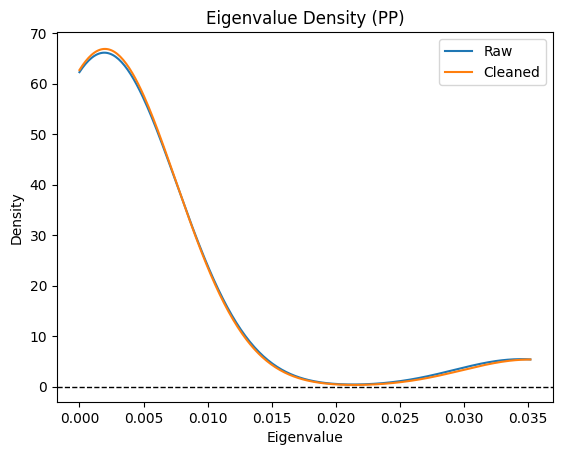

PP condition number → raw: 1.03e+10,  cleaned: 4.99e+09


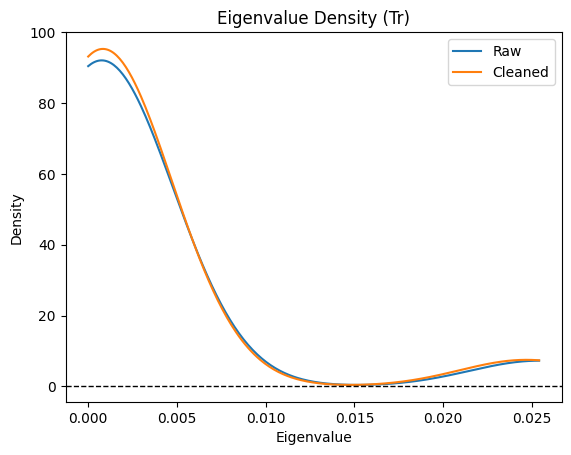

Tr condition number → raw: 5.94e+06,  cleaned: 3.94e+06


In [21]:
compare_eigenvalues(cov_PP, cov_PP_clean, 'PP')
compare_eigenvalues(cov_Tr, cov_Tr_clean, 'Tr')

We clearly see that the covariance at the Tr date is much "cleaner" than the covariance at the PP date. We also see that the percentage change is very unstable around the SOFR. This is not surprising, as we clearly saw that the covariance line and columns corresponding to the SOFR are way smaller than the other values (0.00e^-03). So this jump represents numerical instability more than error in our approach. 

Regarding the eigenvalue density plot, we see the cleaned version is slightly shifted to the right, which shows the impact of putting all the small eigenvalues to a same constant. The tail on the right shows that we have kept the bigger eigenvalues, while in the smaller region, the orange line is slightly above the blue, which shows all the smaller eigenvalues which have been set to a constant. Remember that we are plotting the kernel density, which "smoothes" the actual distribution of the eigenvalues into a continuous curve.

We also see that the condition number is very high initially for both dates, and that the clipping process reduces their magnitude by 2 and 1.5 respectively. This is what is expected, as with unstable random variables such as the covariance and correlation, the condition number is always very high. Nonetheless, the clipping has reduced it, making the matrices more prone to invertability.

(d) Create Euler risk contribution structures for both portfolios at their respective solution dates,
for both the raw sample and the cleaned covariances (four in total). Compare these across
time and across estimators and note your findings. Can you condense the information from
the Euler risk contribution structure into a single number (e.g. by using the Herfindahl index
of the risk contributions)?

To construct the Euler risk‐contribution structures, we proceed as follows. \
Let $\mathbf w$ be the portfolio weights at the solution date and $\Sigma$ the corresponding covariance matrix.  First, we compute the total portfolio risk (standard deviation) $\sqrt{V} = \sigma \;=\;  \sqrt{\mathbf w^\top \Sigma\,\mathbf w}$.\
Next, we obtain the marginal risk contributions
$\mathrm{MRC}_i \;=\;\frac{\partial \sigma}{\partial w_i} \;=\;\frac{(\Sigma\,\mathbf w)_i}{\sqrt{\mathbf w^\top \Sigma\,\mathbf w}} = \frac{(\Sigma\,\mathbf w)_i}{\sigma}$,
and form the Euler risk contributions
$\mathrm{RC}_i \;=\;w_i\,\mathrm{MRC}_i \;=\;w_i\,\frac{(\Sigma\,\mathbf w)_i}{\sigma}$. \
Finally, we normalize by dividing by $\sigma$,
$\mathrm{NRC}_i \;=\;\frac{\mathrm{RC}i}{\sigma}
\quad\Longrightarrow\quad
\sum_{i}\mathrm{NRC}_i = 1$, so that each $\mathrm{NRC}_i$ measures the fraction of total risk attributed to asset i. \
By applying this recipe to both portfolios at their respective dates, and using each of the raw‐sample and cleaned covariances, we obtain the four required Euler risk‐contribution structures.

To summarize the dispersion of our normalized Euler risk contributions $\{NRC_i\}_{i=1}^N$ with a single metric, we compute the Herfindahl index
$H \;=\;\sum_{i=1}^N (NRC_i)^2$. \
By squaring each contribution and summing, $H$ captures concentration: in the extreme of perfect equality $(NRC_i=1/N$ for all $i)$, we get $H=1/N$, indicating maximal diversification, whereas if one asset bears nearly all the risk $(NRC_j\approx1)$, then $H\approx1$, reflecting high concentration.  

https://bookdown.org/compfinezbook/introcompfinr/eulers-theorem-and-risk-decompositions.html

Herfindahl Indexes:
Minimum Herfindal (1/N): 0.07142857142857142
 PP raw:     0.1047
 PP cleaned: 0.1050
 Tr raw:     0.1101
 Tr cleaned: 0.1108


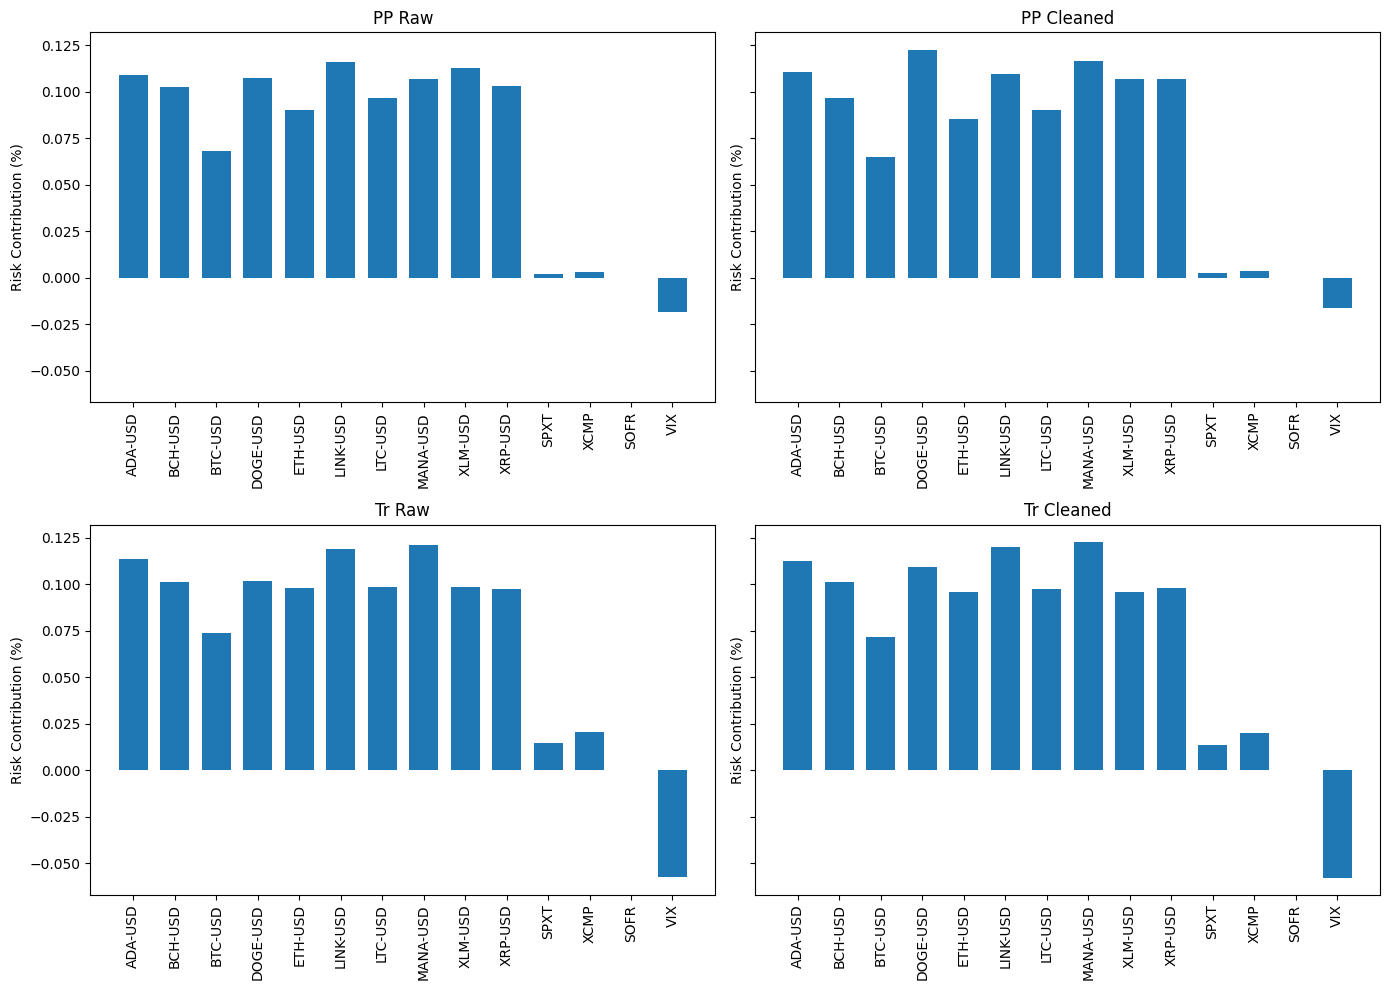

In [22]:
# equally weighted portfolio
w_PP = np.repeat(1/14, 14)
w_Tr =np.repeat(1/14, 14)

asset_names   = list(cov_PP.columns)  # list our asset labels

# functions
def norm_euler_risk_contribution(w, Sigma):
    """
    Compute normalized Euler risk contributions for portfolio w and covariance Sigma.
    Returns an array of length N summing to 1.
    """
    risk   = np.sqrt(w @ Sigma @ w)      # portfolio variance
    mrc = Sigma.dot(w) / risk        # marginal risk contributions
    rc  = w * mrc             # total (Euler) contributions
    return rc / risk            # normalized contributions

def herfindahl(rc):
    """Compute the Herfindahl index (sum of squares) of risk contributions."""
    return np.sum(rc**2)

# Compute the four sets of risk contributions 
rc_PP_raw   = norm_euler_risk_contribution(w_PP,   cov_PP.values)
rc_PP_clean = norm_euler_risk_contribution(w_PP,   cov_PP_clean)
rc_Tr_raw   = norm_euler_risk_contribution(w_Tr,   cov_Tr.values)
rc_Tr_clean = norm_euler_risk_contribution(w_Tr,   cov_Tr_clean)

# Compute Herfindahl indices 
h_PP_raw   = herfindahl(rc_PP_raw)
h_PP_clean = herfindahl(rc_PP_clean)
h_Tr_raw   = herfindahl(rc_Tr_raw)
h_Tr_clean = herfindahl(rc_Tr_clean)

print("Herfindahl Indexes:")
print("Minimum Herfindal (1/N):", 1/n_assets)
print(f" PP raw:     {h_PP_raw:.4f}")
print(f" PP cleaned: {h_PP_clean:.4f}")
print(f" Tr raw:     {h_Tr_raw:.4f}")
print(f" Tr cleaned: {h_Tr_clean:.4f}")

# Bar‐plot the risk contributions 
fig, axes = plt.subplots(2, 2, figsize=(14,10), sharey=True)

cases = [
    (rc_PP_raw,   "PP Raw"),
    (rc_PP_clean, "PP Cleaned"),
    (rc_Tr_raw,   "Tr Raw"),
    (rc_Tr_clean, "Tr Cleaned")
]

# Determine y‐axis limit for consistency
all_rc = np.concatenate([rc_PP_raw, rc_PP_clean, rc_Tr_raw, rc_Tr_clean])
ymax   = all_rc.max() * 1.1

for ax, (rc, title) in zip(axes.flatten(), cases):
    x = np.arange(len(asset_names))
    ax.bar(x, rc, width=0.7)
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(asset_names, rotation=90)
    ax.set_ylabel("Risk Contribution (%)")

plt.tight_layout()
plt.show()

(e) Create a diversification distribution of the portfolios, following the method in Meucci (2009),
and summarize this information as the Effective Number of Bets. Compare this diversification distribution to the Euler risk contributions from d) and compare their respective index
numbers – what do you notice?

Following the method in Meucci (2009), a generic portfolio can be seen either as a combination of the original securites with weights $\bold{w}$, or as a combination of the uncorrelated principal portfolios with weights $\tilde{\bold{w}}\bold{\equiv E^{-1}w}$, where the matrix $\bold{E\equiv (e_1,...,e_N)}$ contains the eigenvectors of $\Sigma$, the returns covariance. \
In terms of the latter, we can introduce the variance concentration curve 
$$v_n\equiv \tilde{w}_n^2 \lambda_n, ~~ n=1,...,N.$$ 
The generic entry $v_n$ of this concentration curve represents the variance due to the n-th principal portfolio. \
The total portfolio variance is the sum of these terms : 
$$\mathrm{Var}{\{R_w\}}=\sum_{n=1}^N v_n$$
Finally, we can compute the diversification distribution : 
$$p_n \equiv \frac{\tilde{w}_n^2 \lambda_n}{\mathrm{Var}{\{R_w\}}}$$

Portfolio diversification can then be summarized by the entropy of $\{p_n\}$, or equivalently by its exponential, the Effective Number of Bets: $ \mathcal{N}_{\rm Ent} \;\equiv\; \exp\!\Bigl(-\sum_{n=1}^N p_n\ln p_n\Bigr). $

https://portfoliooptimizer.io/blog/the-effective-number-of-bets-measuring-portfolio-diversification/ \
https://www.nasdaq.com/articles/evestment/asset-manager-insights/measuring-portfolio-diversification-provides-a-new-lens-for-asset-owners \


In [23]:
def diversification_distribution(cov,w):
    # Return the eigenvalues and eigenvectors
    eigvals, eigvecs = np.linalg.eigh(cov)
    # sort descending
    idx = np.argsort(eigvals)[::-1]
    eigvals = eigvals[idx]
    eigvecs = eigvecs[:,idx]
    # weights
    n = len(eigvals)
    w = w
    # exposures to principal portfolios
    e = eigvecs.T.dot(w)
    # variance contributions
    contrib = e**2 * eigvals
    # normalize to get a probability distribution
    p = contrib / contrib.sum()
    return p

def effective_bets(p):
    # exp(−∑ pᵢ ln pᵢ)
    return np.exp(-np.sum(p * np.log(p)))

# compute for each of our four covariances 
p_PP_raw   = diversification_distribution(cov_PP,w_PP)
p_PP_clean = diversification_distribution(cov_PP_clean,w_PP)
p_Tr_raw   = diversification_distribution(cov_Tr,w_Tr)
p_Tr_clean = diversification_distribution(cov_Tr_clean,w_Tr)

NEnt_PP_raw   = effective_bets(p_PP_raw)
NEnt_PP_clean = effective_bets(p_PP_clean)
NEnt_Tr_raw   = effective_bets(p_Tr_raw)
NEnt_Tr_clean = effective_bets(p_Tr_clean)

print("Effective Number of Bets (NEnt)")
print("--------------------------------")
print(f"Peak-raw    : {NEnt_PP_raw:.2f}")
print(f"Peak-clean  : {NEnt_PP_clean:.2f}")
print(f"Trough-raw  : {NEnt_Tr_raw:.2f}")
print(f"Trough-clean: {NEnt_Tr_clean:.2f}")

# Compare to the Euler‐contribution Herfindahl index H  computed in (d):
#   effective # of assets = 1/H
eff_assets_PP_raw   = 1/h_PP_raw
eff_assets_PP_clean = 1/h_PP_clean
eff_assets_Tr_raw   = 1/h_Tr_raw
eff_assets_Tr_clean = 1/h_Tr_clean

print("\nEffective Number of Assets (1/Herfindahl)")
print("-------------------------------------------")
print(f"Peak-raw    : {eff_assets_PP_raw:.2f}")
print(f"Peak-clean  : {eff_assets_PP_clean:.2f}")
print(f"Trough-raw  : {eff_assets_Tr_raw:.2f}")
print(f"Trough-clean: {eff_assets_Tr_clean:.2f}")

Effective Number of Bets (NEnt)
--------------------------------
Peak-raw    : 1.13
Peak-clean  : 1.13
Trough-raw  : 1.18
Trough-clean: 1.19

Effective Number of Assets (1/Herfindahl)
-------------------------------------------
Peak-raw    : 9.55
Peak-clean  : 9.52
Trough-raw  : 9.08
Trough-clean: 9.02


(f) At the trough date, dateTr: 21-Nov-2022, your EW portfolio will likely have suffered some
losses. Create a rank order of these and compare this to the rank order of risk contributions
estimated in d), using a visual representation and a rank order correlation matrix such as
Kendall’s Tau. What do you notice?

           LossPct  RankLoss  RiskContrib  RankRisk
ADA-USD  -0.884560       1.0     0.112319       3.0
BCH-USD  -0.837804       2.0     0.101471       5.0
LINK-USD -0.782630       3.0     0.119985       2.0
XLM-USD  -0.740862       4.0     0.095740       8.0
DOGE-USD -0.690585       5.0     0.109533       4.0
XRP-USD  -0.662651       6.0     0.097986       6.0
ETH-USD  -0.661407       7.0     0.095644       9.0
LTC-USD  -0.656863       8.0     0.097254       7.0
BTC-USD  -0.651062       9.0     0.071437      10.0
MANA-USD -0.556037      10.0     0.122921       1.0
XCMP     -0.263846      11.0     0.019815      11.0
SPXT     -0.097463      12.0     0.013761      12.0
SOFR      0.012357      13.0    -0.000040      13.0
VIX       0.067303      14.0    -0.057825      14.0
Kendall’s tau = 0.65, p-value = 0.001


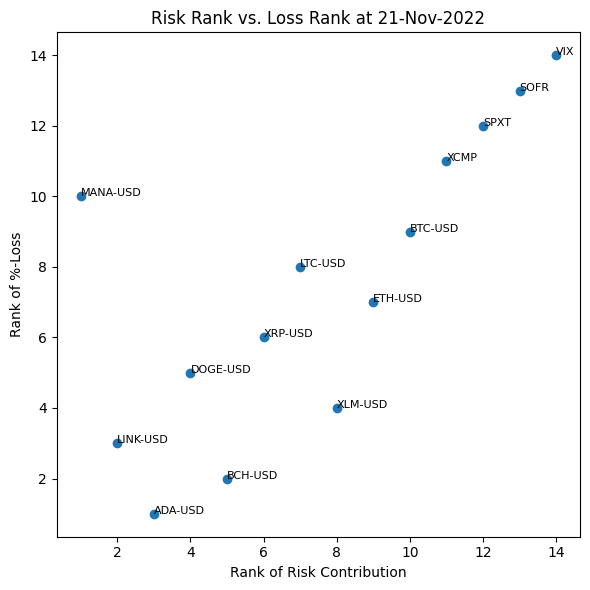

In [24]:
# Compute %‐loss for each asset from peak date to trough date
prices_PP = df.loc[datePP]
prices_Tr = df.loc[dateTr]
losses = (prices_Tr - prices_PP) / prices_PP   # negative numbers = losses
loss_ser = pd.Series(losses, index=df.columns, name="Loss")

# Tr risk contributions 
rc_ser = pd.Series(rc_Tr_clean, index=df.columns, name="RiskContribution")

# 3. Create ranks (1 = biggest loss or biggest risk contribution)
rank_loss = loss_ser.rank(ascending=True)            # most negative → rank 1
rank_rc   = rc_ser .rank(ascending=False)            # largest contribution → rank 1

ranks = pd.concat([loss_ser, rank_loss, rc_ser, rank_rc], axis=1)
ranks.columns = ["LossPct", "RankLoss", "RiskContrib", "RankRisk"]

print(ranks.sort_values("RankLoss"))

# Compute Kendall’s τ between the two rankings
tau, p_value = kendalltau(ranks["RankLoss"], ranks["RankRisk"])
print(f"Kendall’s tau = {tau:.2f}, p-value = {p_value:.3f}")

# Visualize
plt.figure(figsize=(6,6))
plt.scatter(ranks["RankRisk"], ranks["RankLoss"])
for asset in ranks.index:
    plt.text(ranks.at[asset,"RankRisk"],
             ranks.at[asset,"RankLoss"],
             asset,
             fontsize=8)
plt.xlabel("Rank of Risk Contribution")
plt.ylabel("Rank of %‐Loss")
plt.title("Risk Rank vs. Loss Rank at 21-Nov-2022")
plt.tight_layout()
plt.show()

